# 1. Import modules

In [16]:
# standard modules
import sys
from pathlib import Path
from dataclasses import dataclass
from typing import Any

# scientific modules
import pandas as pd
import numpy as np

# visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# custom modules
sys.path.append("../")
from src.utils import read_file
from src.subset_visualization import distribution_bar_for_given_genes
from src.plot import donut_chart

# plotting style
plt.style.use("../../config/DIT_HAP.mplstyle")
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]
AX_WIDTH, AX_HEIGHT = plt.rcParams["figure.figsize"]

# 2. Configurations

In [15]:
@dataclass
class Config:
    project_dir: Path = Path("../../results/HD_DIT_HAP_generationRAW")

    cluster_column: str = "revised_cluster"

    @property
    def enrichment_dir(self) -> Path:
        return self.project_dir / "19_enrichment_analysis"

    @property
    def gene_features(self) -> pd.DataFrame:
        return read_file(Path("../../resources/pombase_data/collected_pombe_gene_features.csv"), **{"na_values": ["none"]})
    
    @property
    def cluster_data(self) -> pd.DataFrame:
        return read_file(self.project_dir / '18_gene_level_clustering' / 'kmeans_cluster_result.tsv')
    
    @property
    def go_enrichment_results(self) -> pd.DataFrame:
        return read_file(self.enrichment_dir / "gene_ontology_enrichment_results.xlsx", **{"sheet_name": "Full GO Enrichment"})
    
cfg = Config()

# 3. Preparation

In [3]:
def get_paralog_cluster(x: Any, genes2cluster: dict[str, int]) -> Any:
    """ Get the paralog cluster representation for a given paralog string."""
    if isinstance(x, str):
        genes = x.split(",")
        gene_clusters = []
        for gene in genes:
            if gene not in genes2cluster:
                gene_clusters.append(gene)
            else:
                gene_clusters.append(str(genes2cluster[gene]))
        return ",".join(gene_clusters)
    else:
        return x

def get_paralog_group(row: pd.Series) -> str:
    """ Get the paralog group representation for a given row."""
    if pd.isna(row["Paralog"]):
        return "Single-copy"
    else:
        return "|".join(sorted(list(set(row["Gene_name"].split("|") + row["Paralog"].split("|")))))

In [4]:
sysID2name = dict(zip(cfg.gene_features["Systematic_ID"], cfg.gene_features["Gene_name"]))
name2cluster_dict = dict(zip(cfg.cluster_data["Name"], cfg.cluster_data[cfg.cluster_column]))
cluster_labels = sorted(cfg.cluster_data[cfg.cluster_column].unique().tolist())

In [5]:
cluster_results_with_gene_features = pd.merge(
    cfg.cluster_data, 
    cfg.gene_features[["Systematic_ID", "Gene_name", "Gene_product", "mRNA_abundance", "Paralog", "RNA_abundance_in_spores", "paralog_count"]], 
    left_on="Systematic ID", right_on="Systematic_ID", how="outer"
)

cluster_results_with_gene_features["Paralog_cluster"] = cluster_results_with_gene_features.apply(lambda x: get_paralog_cluster(x["Paralog"],name2cluster_dict), axis=1)
cluster_results_with_gene_features["Paralog_group"] = cluster_results_with_gene_features.apply(get_paralog_group, axis=1)

# 4. Visualize the given genes or terms

In [33]:
def given_subset_analysis(
    cluster_data_df: pd.DataFrame,
    cluster_column: str,
    genes: list[str],
    gene_column: str,
    feature_column: str
):
    # Subset the cluster data for the given genes
    subset_cluster_data = cluster_data_df.query(f"{gene_column} in @genes").copy()

    # paralog type classification
    single_copy_subunits = subset_cluster_data.query("Paralog_group == 'Single-copy'").dropna(subset=[feature_column]).copy()
    high_expressing_subunits = subset_cluster_data.query("Paralog_group != 'Single-copy' and paralog_count == 1").groupby("Paralog_group").apply(lambda x: x.sort_values(by="mRNA_abundance", ascending=False).head(1)).dropna(subset=[feature_column]).reset_index(drop=True)
    low_expressing_subunits = subset_cluster_data.query("Paralog_group != 'Single-copy' and paralog_count == 1").groupby("Paralog_group").apply(lambda x: x.sort_values(by="mRNA_abundance", ascending=True).head(1)).dropna(subset=[feature_column]).reset_index(drop=True)
    single_copy_subunits["Paralog_type"] = "Single-copy\n(n=" + str(single_copy_subunits.shape[0]) + ")"
    high_expressing_subunits["Paralog_type"] = "High-expressing paralog\n(n=" + str(high_expressing_subunits.shape[0]) + ")"
    low_expressing_subunits["Paralog_type"] = "Low-expressing paralog\n(n=" + str(low_expressing_subunits.shape[0]) + ")"
    concat_subunits = pd.concat([single_copy_subunits, high_expressing_subunits, low_expressing_subunits])

    # Plotting
    fig, axes = plt.subplot_mosaic([['A', 'A', 'A'], ['B', 'C', 'D']], height_ratios=[1,6], width_ratios=[1,1,1], figsize=(AX_WIDTH*3, AX_HEIGHT+1))

    # Distribution bar plot
    distribution_bar_for_given_genes(
        cluster_results_with_gene_features,
        genes,
        cluster_column,
        "Name",
        ax=axes['A'],
        title="Distribution of Selected Genes Across Clusters"
    )

    sizes = [20, 19, 18, 62 - 20 - 19 - 18]
    labels = ['Cytoplasmic\naminoacyl-tRNA\nligase', 'translation initiation factor', 'ribosomal\nprotein', 'Others']
    donut_center_text = "cytoplasmic\ntranslation"

    donut_chart(
        sizes,
        labels,
        COLORS[:len(sizes)],
        center_text=donut_center_text,
        ax=axes['B']
    )

    sns.swarmplot(x=feature_column, y="Paralog_type", data=concat_subunits, ax=axes['C'], alpha=0.6)
    sns.violinplot(x=feature_column, y="Paralog_type", data=concat_subunits, color="lightgray", alpha=0.4, ax=axes['C'], density_norm="width", inner_kws={"linewidth": 1, "box_width": 30, "color":"gray", "alpha":0.8})
    axes['C'].tick_params(axis='both')
    axes['C'].set_xlabel(feature_column)
    axes['C'].set_ylabel("")

    x_all = cluster_results_with_gene_features["um"]
    y_all = cluster_results_with_gene_features["lam"]
    axes['D'].scatter(x_all, y_all, c='lightgray', s=30, alpha=0.4)

    for idx, (Paralog_type, Paralog_type_df) in enumerate(concat_subunits.groupby("Paralog_type")):
        x = Paralog_type_df["um"]
        y = Paralog_type_df["lam"]
        axes['D'].scatter(x, y, c=COLORS[idx-1], s=30, label=str(Paralog_type))
    axes['D'].legend(loc='upper right')
    axes['D'].set_xlabel("um")
    axes['D'].set_ylabel("lam")

    plt.show()
    plt.close()

## Cytoplasmic translation

In [34]:
cytoplasmic_tranlsation_pop_items = cfg.go_enrichment_results.query("namespace == 'BP' and term == 'cytoplasmic translation'")["pop_items"].iloc[0]
covered_cytoplasmic_tranlsation_genes = cytoplasmic_tranlsation_pop_items.split(",")

/tmp/ipykernel_236130/3430460241.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_expressing_subunits = subset_cluster_data.query("Paralog_group != 'Single-copy' and paralog_count == 1").groupby("Paralog_group").apply(lambda x: x.sort_values(by="mRNA_abundance", ascending=False).head(1)).dropna(subset=[feature_column]).reset_index(drop=True)
/tmp/ipykernel_236130/3430460241.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silen

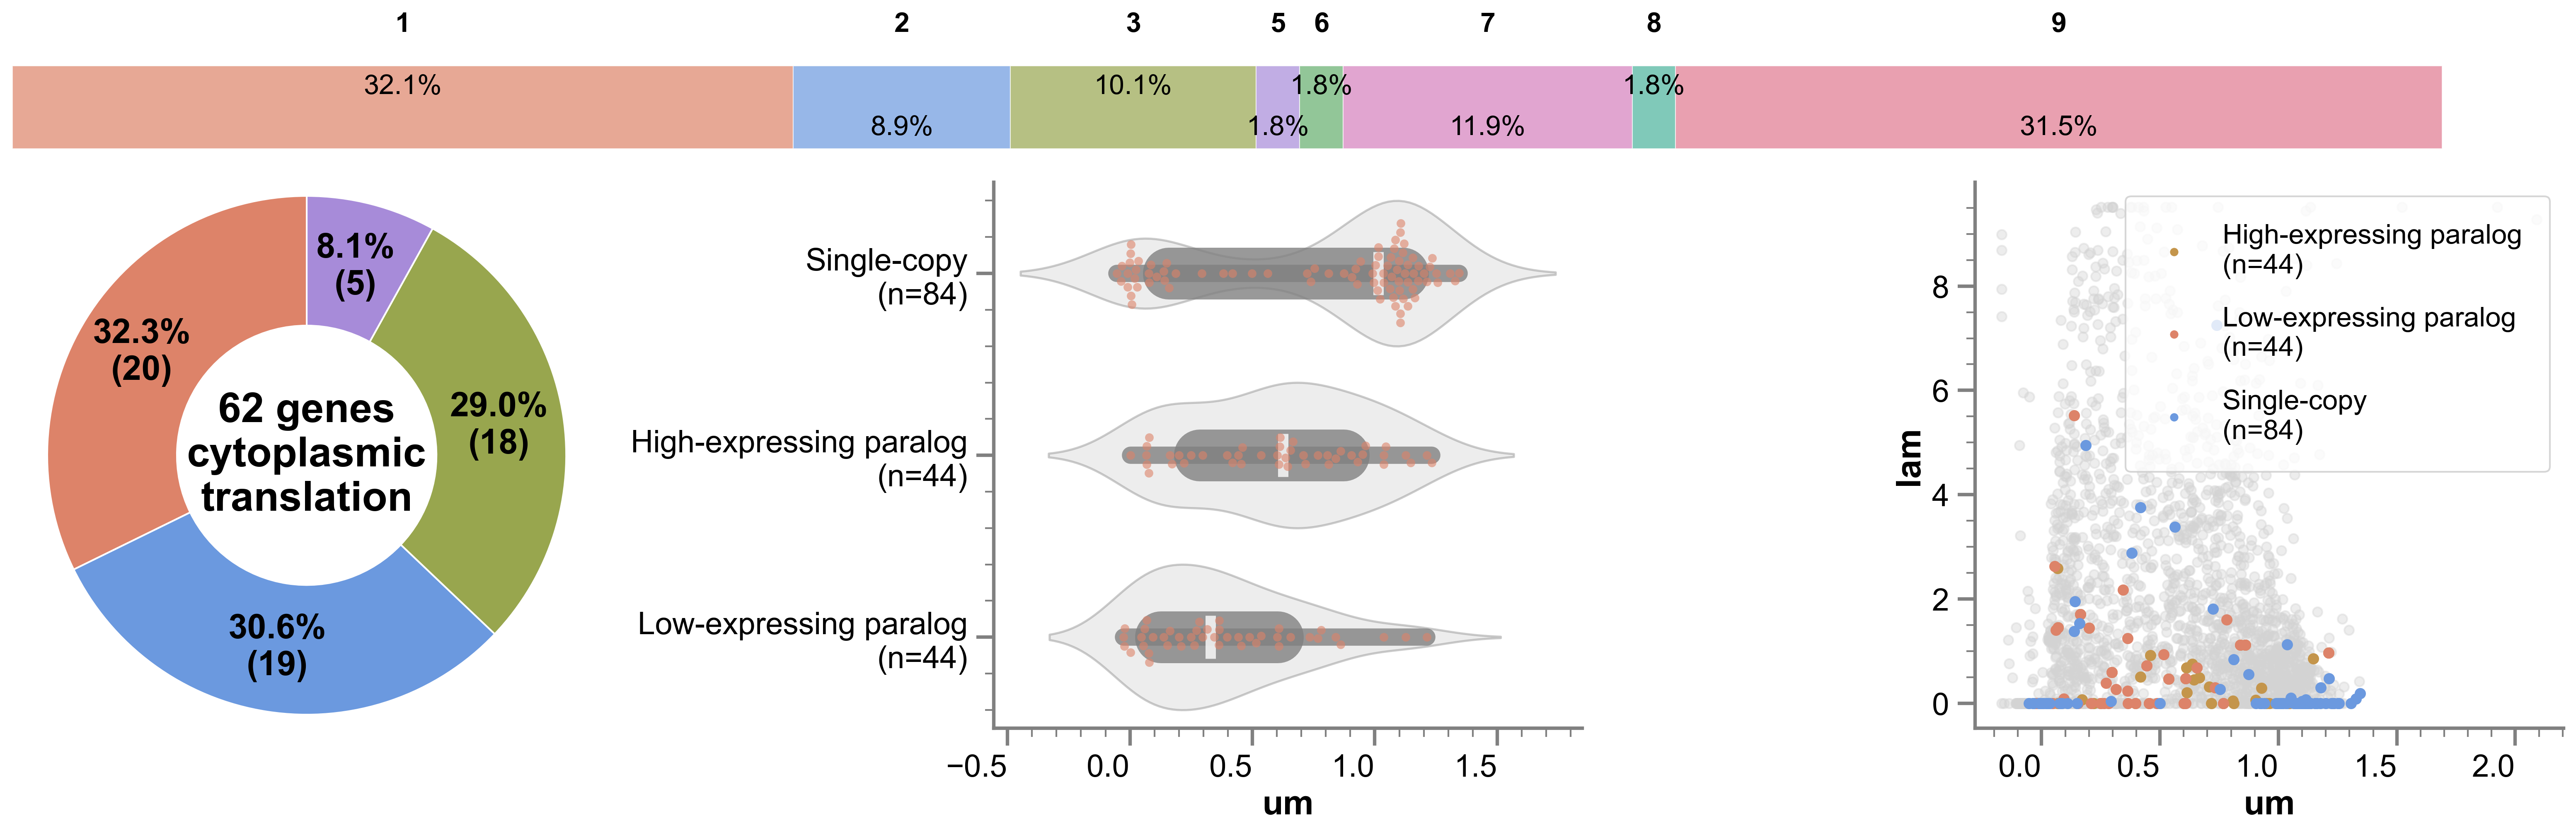

In [35]:
given_subset_analysis(
    cluster_results_with_gene_features,
    cfg.cluster_column,
    covered_cytoplasmic_tranlsation_genes,
    "Name",
    "um"
)

## cytosolic ribosome

/tmp/ipykernel_236130/3430460241.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_expressing_subunits = subset_cluster_data.query("Paralog_group != 'Single-copy' and paralog_count == 1").groupby("Paralog_group").apply(lambda x: x.sort_values(by="mRNA_abundance", ascending=False).head(1)).dropna(subset=[feature_column]).reset_index(drop=True)
/tmp/ipykernel_236130/3430460241.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silen

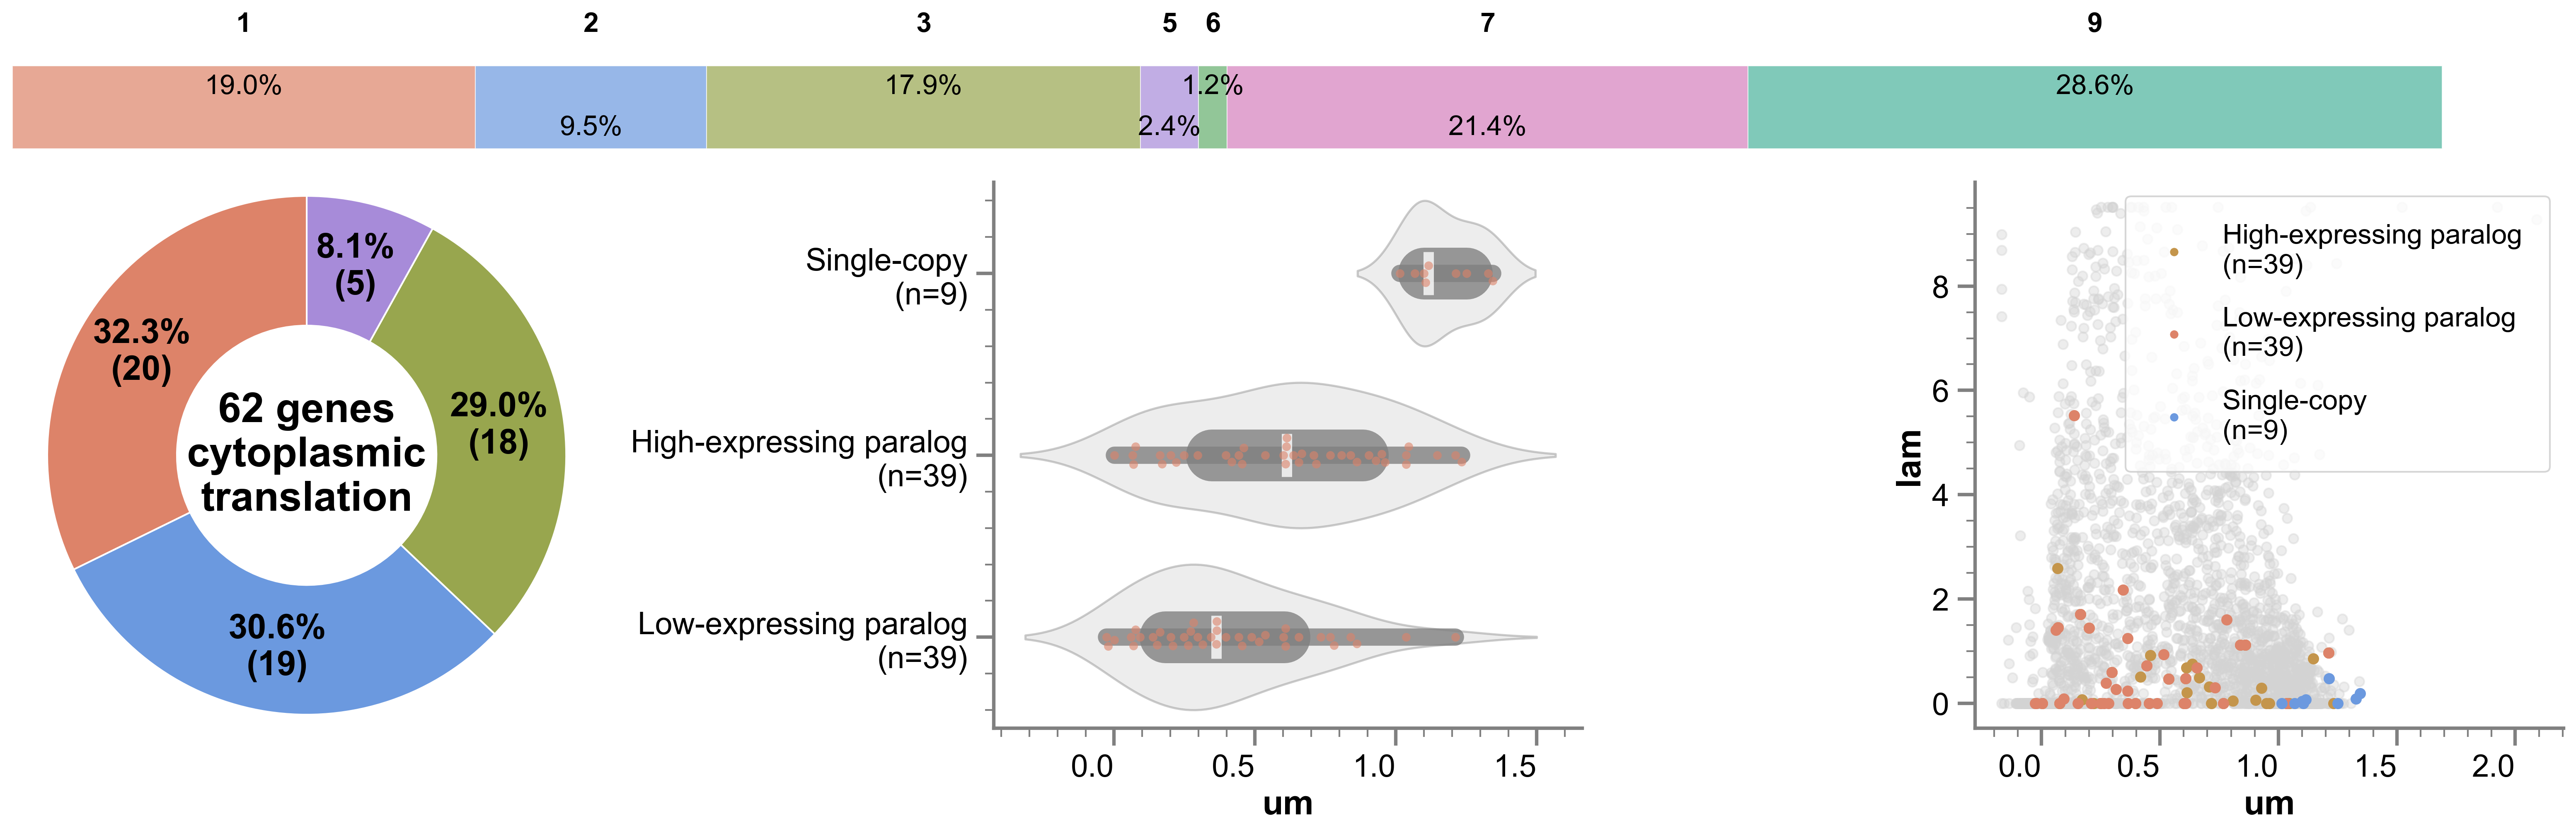

In [36]:
cytosolic_ribosome_genes = "gcn20,rlp7,rpl101,rpl102,rpl13,rpl14,rpl15,rpl1502,rpl1603,rpl1701,rpl1702,rpl1801,rpl1901,rpl2001,rpl2101,rpl2102,rpl2301,rpl2302,rpl2401,rpl2402,rpl2501,rpl2502,rpl2701,rpl2802,rpl29,rpl3002,rpl3401,rpl3402,rpl35,rpl3601,rpl3602,rpl3703,rpl3801,rpl401,rpl4101,rpl502,rpl701,rpl702,rpl8,rpl901,rpp0,rpp101,rpp102,rpp103,rpp201,rpp202,rps1001,rps1002,rps101,rps102,rps1101,rps1102,rps1201,rps1202,rps13,rps1501,rps1601,rps1602,rps1701,rps1702,rps1801,rps1802,rps1901,rps1902,rps2,rps2201,rps2202,rps2501,rps2502,rps2602,rps2801,rps2802,rps29,rps3,rps3002,rps401,rps402,rps403,rps5,rps502,rps601,rps602,rps801,rps902,ubi2,ubi3"
cytosolic_ribosome_genes = cytosolic_ribosome_genes.split(",")
# remove rpl29 and gcn20 due to their special expression patterns
filtered_cytosolic_ribosome_genes = [gene for gene in cytosolic_ribosome_genes if gene not in ['rpl29', 'gcn20']]
given_subset_analysis(
    cluster_results_with_gene_features,
    cfg.cluster_column,
    filtered_cytosolic_ribosome_genes,
    "Name",
    "um"
)

## cytoplasmic tRNA ligase

/tmp/ipykernel_236130/3430460241.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_expressing_subunits = subset_cluster_data.query("Paralog_group != 'Single-copy' and paralog_count == 1").groupby("Paralog_group").apply(lambda x: x.sort_values(by="mRNA_abundance", ascending=False).head(1)).dropna(subset=[feature_column]).reset_index(drop=True)
/tmp/ipykernel_236130/3430460241.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silen

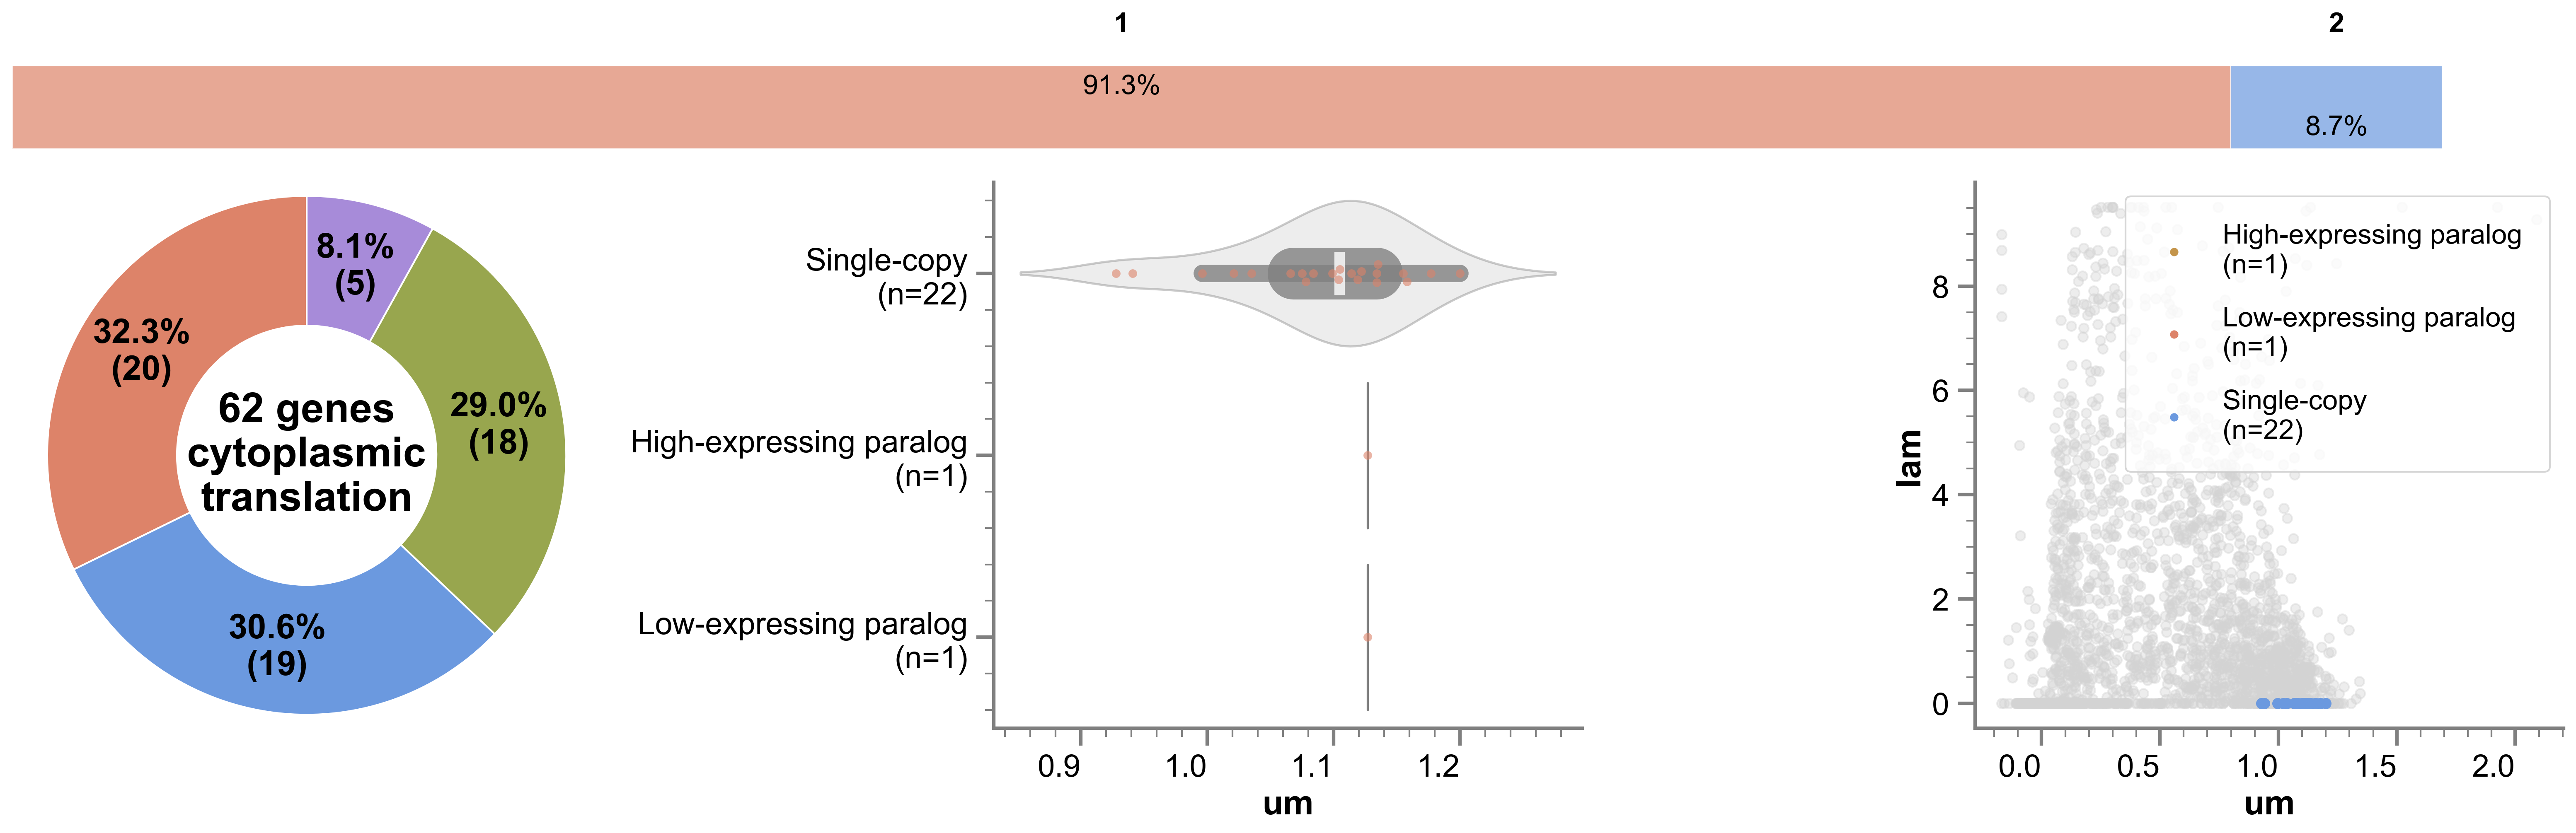

In [37]:
cyto_tRNA_synthetases = ["nrs1","drs1","gus1","qrs1","irs1","lrs1","krs1","rar1","frs2","frs1","prs1","srs1","trs1","erf1","sup35","wrs1","vrs1","rli1","ala1","msr1","SPAC29E6.06c","grs1","hrs1"]
given_subset_analysis(
    cluster_results_with_gene_features,
    cfg.cluster_column,
    cyto_tRNA_synthetases,
    "Name",
    "um"
)